In [517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import NearestNeighbors

# Extract Constant Velocity Data Function

In [518]:
# Function used for taking constant velocity data from the DataFrame

def test_vel(df):
    
    metric = df.quantile(
    q=0.5,                      # The percentile to calculate
    axis=0,                     # The axis to calculate the percentile on
    numeric_only=True,          # To calculate only for numeric columns
    interpolation='linear'      # The type of interpolation to use when the quantile is between 2 values
    )
    
    temp = df[df['vel'] > metric[0]]
    temp.reset_index(inplace = True, drop = True)
    
    return temp
       

# Outlier Removal Function

In [519]:
def od_remove(df):
    
    # Instantiate model
    nbrs = NearestNeighbors(n_neighbors = 3)

    # fit model
    nbrs.fit(df)

    # distances and indexes of k-neaighbors from model outputs
    distances, indexes = nbrs.kneighbors(df)

    # inding the indices of the data above 75% quartile range
    met = np.quantile(distances.mean(axis =1),q=0.75)

    # Dropping the data
    df.drop(index = np.argwhere(distances.mean(axis =1) > met)[:,0], inplace = True)
    
    return data

# Brake Related Data

In [520]:
# Brake Disc Diameter
Db = 280*1e-2

# Disc Inner Radius
# Ri = 120*1e-3

# Disc Outer Radius
# Ro = 240*1e-3

# Number of pad surfaces
Ns = 2

# Number of pistons per pad
Np = 2

# Rm = (Ro + Ri)/2.0

Rm = 13.6

# Brake Friction Constant calculation
fric_const = 4*10/(np.pi*Db**2*Rm*Np*Ns)

# Reading the Data File

In [521]:
# 50N.pkl has all non-negative data

dict = pd.read_pickle('40N.pkl')

In [522]:
dict.keys()

dict_keys(['1kmph', '2kmph', '3kmph', '4kmph', '5kmph', '6kmph', '7kmph', '8kmph', '9kmph', '10kmph', '15kmph', '20kmph', '25kmph'])

In [523]:
not bool(dict['1kmph']['press'])

True

# Main Code

In [524]:
dict_clean = {}

In [525]:

for i in np.arange(0,len(dict),1):
    
    #     print(i)

    sheet_name = list(dict.keys())[i]
    
    # Checking for Empty dictionary
    
    if (not bool(dict[sheet_name]['press'])):
        
        dict[sheet_name]['mu'] = {}
        d = dict[sheet_name]
        
    # Storing values in global pickle dictionary
    #   print(f'{sheet_name}')
        dict_clean[sheet_name] = d
        
    else: 

        df= pd.DataFrame(dict[sheet_name])

        # Getting constant velocity dataset
        data = test_vel(df)

        # Calculating Coefficient of Friction
        pd.set_option('mode.chained_assignment', None)
        data['mu'] = fric_const*(data['T_SG']/data['press'])

        # Removing the Outliers
        data = od_remove(data)

        # Storing the data in dictionary
        d = data.to_dict()

        # Storing values in global pickle dictionary
    #     print(f'{sheet_name}')
        dict_clean[sheet_name] = d

In [526]:
dict_clean.keys()

dict_keys(['1kmph', '2kmph', '3kmph', '4kmph', '5kmph', '6kmph', '7kmph', '8kmph', '9kmph', '10kmph', '15kmph', '20kmph', '25kmph'])

In [527]:
dict_clean['3kmph'].keys()

dict_keys(['vel', 'T_cor', 'F_lever', 'T_SG', 'press', 'temp', 'pos', 'mu'])

# Plots

In [528]:
speed = data['vel'].mean()

In [529]:
force = data['F_lever'].max()

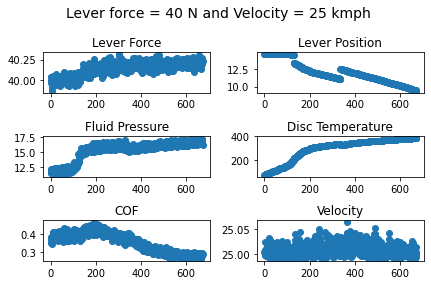

In [530]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(3, 2)

# For Lever Force
axis[0, 0].scatter(np.arange(0,len(data),1),data['F_lever'])
axis[0, 0].set_title("Lever Force")

# Lever Position
axis[0, 1].scatter(np.arange(0,len(data),1),data['pos'])
axis[0, 1].set_title("Lever Position")
  
# For Fluid Pressure
axis[1, 0].scatter(np.arange(0,len(data),1),data['press'])
axis[1, 0].set_title("Fluid Pressure")
  
# For Disc Temperature
axis[1,1].scatter(np.arange(0,len(data),1),data['temp'])
axis[1,1].set_title("Disc Temperature")
  
# For Velocity
axis[2,1].scatter(np.arange(0,len(data),1),data['vel'])
axis[2,1].set_title("Velocity")

# For Coefficient of Friction
axis[2,0].scatter(np.arange(0,len(data),1),data['mu'])
axis[2,0].set_title("COF")


plt.suptitle(f'Lever force = {int(force)} N and Velocity = {int(speed)} kmph', fontsize=14)

figure.tight_layout()
  
# Combine all the operations and display
plt.show()

# Storing the cleaned data

In [531]:
f = open("40N_Od_removed.pkl","wb")

pickle.dump(dict_clean,f)

# close file
f.close()